© 2018 Suzy Beeler. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This exercise was generated from a Jupyter notebook. You can download the notebook [here](bacterial_growth_revisited.ipynb).
___

# Objective 

Now that we've learned a little about Bayesian inference, we will revisit the bacterial growth problem and learn how we can determine the posterior probability distribution for a parameter value (i.e. the growth rate) given our data. What makes Bayesian inference so powerful is that we won't just know the most likely growth rate as we did before, but we will now know the likelihood of a *range* of possible growth rates. 

# Revisiting the bacterial growth data

In [1]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For pretty plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# used for opening csv files and manipulating data spreadsheets
import pandas as pd

From the image analysis we previously did, we ultimately ended up with the area of bacteria over time, normalized such that the area was $1$ at $t=0$. Let's load in this data using `pandas`, an incredibly useful package that can be used to read in, manipulate, and create dataframes (i.e. spreadsheets).

In [2]:
# use pandas to read in the file into a dataframe
dataframe = pd.read_csv("./data/normalized_bacterial_areas.csv")

# show the data
dataframe

,area,time(mins)
0,1.000000,0
1,1.154062,5
2,1.408350,10
3,1.583774,15
4,1.946165,20
5,2.222030,25
6,2.800410,30
7,3.081454,35
8,3.830295,40
9,4.333154,45


We see that data is formatted in two columns, one with the normalized area, and one with the corresponding time in minutes. Let's re-plot the data to remind ourselves what it looks like.

Text(0,0.5,'normalized area')

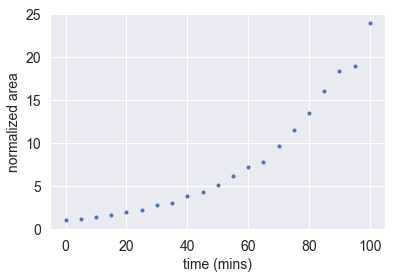

In [3]:
# extract the areas and times from the dataframe
areas = dataframe["area"]
times = dataframe["time(mins)"]

# plot the data
plt.plot(times, areas, '.')
plt.xlabel("time (mins)")
plt.ylabel("normalized area")

Great! We still see an exponential growth curve. Now how do we go about using Bayesian inference to determine the probability of certain growth rates given the data that we have here?

# A Bayesian approach to parameter estimation

Recall that in a Bayesian framework, we are interested in quantifying the probability of our model *given* our data, or $P(M|D)$, where

$$P(M|D) \propto P(D|M)P(M).$$

In order to optimize this posterior probability, we need to specify the prior, $P(M)$ and the likelihood, $P(D|M)$.

## The prior

The prior, $P(M)$, is supposed to reflect our best guess of the parameter value $\lambda$ before the data was acquired. For the doubling time of bacteria, since we don't know anything about the growth conditions that were used, let's give generous bounds on the minimum and maximum possible doubling times, say $10$ mins to $1440$ mins (i.e. a day). As we showed [previously](bacterial_growth.ipynb), the doubling time $\tau = \frac{ln(2)}{\lambda}$. This means doubling times of $10$ and $1440$ mins correspond to growth rates of $\approx 0.07 \ \text{min}^{-1}$ and $\approx 0.0005 \  \text{min}^{-1}$, respectively. For an uninformative prior, we will say that any growth rate in this range from $0.0005$ to $0.07 \  \text{min}^{-1}$ will be equally likely, and any growth rate outside of this range is not possible (i.e. has $0$ probability). Let's write a function `prior`, that will return the prior probability of a given growth rate, `lam`.

In [4]:
def prior(lam, lam_min=0.0005, lam_max=0.07):
    """
    Returns the prior probability of a given growth rate, lam.
    Uniform probability for all values of lam that lie between
    lam_min and lam_max. 
    """
    # check that lam is within the bounds
    if lam_min <= lam <= lam_max:
        return 1
    
    # otherwise, the probability is 0
    else:
        return 0

Let's plot the prior probability for a range of growth rates:

Text(0,0.5,'prior probability')

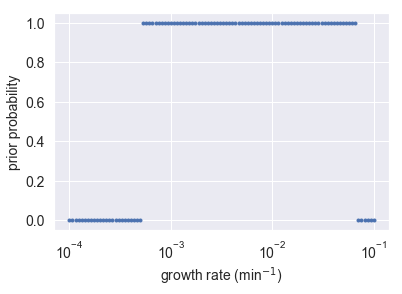

In [5]:
# specify lambdas from 10^-4 to 10^-1
lams = np.logspace(-4,-1,100)

# calculate prior probability for each lam in lams
prior_prob = [prior(lam) for lam in lams] 

# plot 
plt.semilogx(lams, prior_prob, '.')
plt.xlabel("growth rate (min$^{-1}$)")
plt.ylabel("prior probability")

[SMB note: this prior is not normalized, but this is okay since we are ultimately working with proportionalities rather than absolute values. An unnormalized prior doesn't change what the optimal parameter will be.]

## The likelihood

Now that we have specified the prior, we need to formulate the likelihood, $P(D|\lambda)$. That is, for a given model (growth rate $\lambda$ in our case), we need to determine how likely it would be to get our data. To illustrate what we are trying to get at here, let's plot several different models over our data.

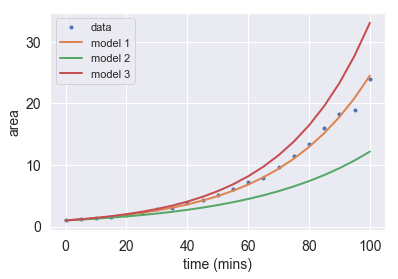

In [6]:
# plot the data
plt.plot(times, areas, '.')

# plot different models of growth by tuning lambda
plt.plot(times, np.exp(0.032*times))
plt.plot(times, np.exp(0.025*times))
plt.plot(times, np.exp(0.035*times))

# label plot
plt.xlabel("time (mins)")
plt.ylabel("area")
plt.legend(["data","model 1", "model 2", "model 3"])

From the plot above, model 1 seems to fit the data better than models 2 and 3, and accordingly it seems that model 1 should be considered more *likely*. But how to we quantify this likelihood? If we assume the errors in our measurements to be normally distributed (not unreasonable given the central limit theorem), we can determine how likely a given parameter choice is by how much our data deviates from the resulting model. 

By the normal distribution, the probability of getting a given data point, $D_i$ at corresponding time $t_i$ is

$$P(D_i | \lambda, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \text{exp}\ \bigg\{-\frac{(D_i-e^{\lambda t_i})^2}{2\sigma^2}\bigg\},$$

where we've introduced a new parameter $\sigma$, which represents the spread of our errors. For our purposes, we aren't interested in estimating the actual value of $\sigma$, although we could. This means we can marginalize out this $\sigma$ by integrating over all values of $\sigma$. This means the likelihood of all of our data, $D$, is

$$
\begin{align}
P(D | \lambda, \sigma) &= \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}} \text{exp}\ \bigg\{-\frac{(D_i-e^{\lambda t_i})^2}{2\sigma^2}\bigg\}, \\
P(D | \lambda, \sigma) &\propto \prod_{i=1}^{N} \frac{1}{\sigma} \ \text{exp}\ \bigg\{-\frac{(D_i-e^{\lambda t_i})^2}{2\sigma^2}\bigg\}, \\
P(D | \lambda) &\propto \int_{0}^{\infty} d\sigma \prod_{i=1}^{N} \frac{1}{\sigma} \ \text{exp}\ \bigg\{-\frac{(D_i-e^{\lambda t_i})^2}{2\sigma^2}\bigg\}, \\
P(D | \lambda) &\propto \Bigg[ \sum_{i=1}^{N} (D_i-e^{\lambda t_i})^2 \Bigg]^{-\frac{N-1}{2}}.
\end{align}
$$ 

[SMB note: This is what has been giving me so much trouble. I don't have a great handle on how to discuss this, unfortunately.]

In [7]:
def likelihood(D, times, lam):
    """
    Returns the likelihood of the data, D, given the growth rate, lam.
    """
    # N is the number of data points
    N = len(D)
    
    # get the theory curve for the given lam
    D_theory = np.exp(lam*times)
    
    # get the residuals
    residuals = D - D_theory
    
    # calculate the total likelihood and return
    likelihood = sum(residuals**2)**(-(N-1)/2) 
    return likelihood

# The posterior

Now we can bring the prior and likelihood together to get the posterior probability. 

In [8]:
def posterior(D, times, lam):
    """
    Returns the posterior probability, by simply calling the prior
    and likelihood functions we've written
    """
    prior_prob = prior(lam)
    likelihood_prob = likelihood(D, times,lam)
    return prior_prob*likelihood_prob

Now, we are are finally ready for the moment of truth. Let's see what our posterior probability looks like for a range of possible $\lambda$s.

Text(0,0.5,'posterior probability')

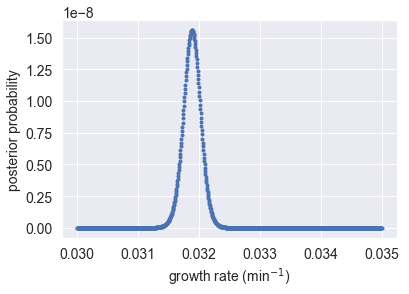

In [9]:
# a little guess and check to narrow down on this region of lambda
lams = np.linspace(0.03,0.035,1000)

# calculate posterior probability for each lam in lams
posterior_prob = [posterior(areas,times,lam) for lam in lams] 

# plot 
plt.plot(lams, posterior_prob, '.')
plt.xlabel("growth rate (min$^{-1}$)")
plt.ylabel("posterior probability")

We see that only a fairly narrow range of values for $\lambda$ yield a high posterior probability. To clean this plot up a bit, let's normalize the probability to sum to $1$, and convert growth rate to doubling time, which I find a little more intuitive to think about. 

Text(0,0.5,'posterior probability')

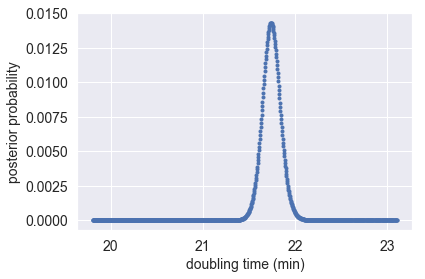

In [10]:
# normalize the probability 
normed_post = np.array(posterior_prob) / sum(posterior_prob)

# convert lambdas to doubling times
taus = np.log(2)/lams 

# plot 
plt.plot(taus, normed_post, '.')
plt.xlabel("doubling time (min)")
plt.ylabel("posterior probability")

We see that the optimal doubling time is between `21` and `22` minutes, same as before. Furthermore, from having taking a Bayesian inference approach, we see that the probability of any other doubling time drops of quickly as you deviate from the optimum. 

In [23]:
import numpy as np
import scipy.stats as st
import emcee

def log_posterior(params, t, area):
    if np.any(params < 0):
        return -np.inf

    k, N0, sigma = params
    
    # Prior
    log_prior_k = st.norm.logpdf(k, 0.06, 0.03)
    log_prior_N0 = st.norm.logpdf(N0, 1, 0.1)
    log_prior_sigma = st.norm.logpdf(sigma, 0.3, 0.1)
    
    # Likelihood
    log_like = np.sum(st.norm.logpdf(area, N0*np.exp(k*t), sigma))
    
    return log_prior_k + log_prior_N0 + log_prior_sigma + log_like

n_chains = 20
sampler = emcee.EnsembleSampler(n_chains, 
                                3, 
                                log_posterior, 
                                args=(dataframe['time(mins)'].values,
                                      dataframe['area'].values))

p0_k = np.random.normal(0.06, 0.005, n_chains)
p0_N0 = np.random.normal(1, 0.01, n_chains)
p0_sigma = np.random.normal(0.1, 0.01, n_chains)
p0 = np.vstack((p0_k, p0_N0, p0_sigma)).T
sampler.run_mcmc(p0, 2000)

(array([[0.0307495 , 1.10555752, 0.42336829],
        [0.03122732, 1.05258276, 0.4957711 ],
        [0.02989883, 1.18547259, 0.44083955],
        [0.0315624 , 1.01985461, 0.39924339],
        [0.03067141, 1.12137929, 0.46172891],
        [0.0309043 , 1.10765596, 0.63341817],
        [0.03090542, 1.09217697, 0.4512162 ],
        [0.03007539, 1.17320765, 0.45205919],
        [0.030944  , 1.09185718, 0.40613279],
        [0.03118845, 1.04721151, 0.3972527 ],
        [0.03090805, 1.10732406, 0.40637757],
        [0.03051196, 1.11630979, 0.51517706],
        [0.03031506, 1.16178787, 0.40845034],
        [0.0309048 , 1.08002107, 0.49043194],
        [0.03067602, 1.12868307, 0.45320991],
        [0.03159487, 1.04341518, 0.46189654],
        [0.03112586, 1.06845969, 0.40900522],
        [0.03022563, 1.15307431, 0.41483224],
        [0.03043816, 1.12512852, 0.37255318],
        [0.03036001, 1.15983939, 0.37797668]]),
 array([-11.10531749, -12.64176331, -12.52869913, -14.04277068,
        -11.52